# Выпускной проект курса Аналитика даннных от Яндекс Практикум 

# Проект по А/B-тестированию 

## 1. Введение

**Цель:**

Оценить корректность проведения A/B теста и проанализировать его результаты.

**Задачи:**

- Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- Проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.
- Проанализировать результаты теста.    

**Техническое задание:**

- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
   - конверсии в просмотр карточек товаров — событие product_page
   - просмотры корзины — product_cart
   - покупки — purchase.

**Описание данных:**

ab_project_marketing_events.csv -  **календарь маркетинговых событий на 2020 год;**

Структура файла:

- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

final_ab_new_users.csv - **все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;**

Структура файла:

- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

final_ab_events.csv - **все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;**

Структура файла:

- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

final_ab_participants.csv -  **таблица участников тестов.**

Структура файла:

- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

**План исследования:**

- Исследуем данные:
  - Требуется ли преобразование типов?
  - Присутствуют ли пропущенные значения и дубликаты? Если да, то какова их природа?
- Оценим корректность проведения теста. Обратим внимание на:
  - Соответствие данных требованиям технического задания. Проверим корректность всех пунктов технического задания.
  - Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.
  - Аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах       теста одновременно. Проверим равномерность распределения пользователей по тестовым группам и правильность их формирования.
- Проведем исследовательский анализ данных:
  - Количество событий на пользователя одинаково распределены в выборках?
  - Как число событий в выборках распределено по дням?
  - Как меняется конверсия в воронке в выборках на разных этапах?
  - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
- Проведем оценку результатов A/B-тестирования:
  - Что можно сказать про результаты A/B-тестирования?
  - Проверим статистическую разницу долей z-критерием.
- Сделаем выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Напишем общее заключение о корректности проведения теста.

## 2. Исследование и преобразование данных.

Загружаем необходимые библиотеки:

In [1]:
! pip install matplotlib -U

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
import seaborn as sns
import math

! pip install plotly
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')

     ---------------------------------------- 7.6/7.6 MB 1.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2


### Изучение и преобразование данных из таблицы ab_project_marketing_events

Загружаем данные:

In [3]:
ab_project_marketing_events = pd.read_csv('C:\\Users\\77281\\Downloads\\ab_project_marketing_events.csv')

Изучим таблицу:

In [5]:
display(ab_project_marketing_events)
ab_project_marketing_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Таблица **ab_project_marketing_events** (календарь маркетинговых событий на 2020 год) содержит сведения о 13 маркетинговых событиях на 2020 год, регионы и даты их проведения. В столбцах 'start_dt' и 'finish_dt' необходимо преобразовать данные из типа object в datetime.

Приведем даты к datetime:

In [6]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

Проверим на явные дубликаты и пропуски:

In [8]:
ab_project_marketing_events.duplicated().sum()

0

In [9]:
ab_project_marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Пропусков и дубликатов не содержит. Дальнейшие преобразования не нужны.

### Изучение и преобразование данных из таблицы final_ab_new_users

Загружаем данные:

In [11]:
final_ab_new_users = pd.read_csv('C:\\Users\\77281\\Downloads\\final_ab_new_users.csv')


Изучим таблицу:

In [13]:
display(final_ab_new_users)
final_ab_new_users.info()
final_ab_new_users.duplicated().sum()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


0

Таблица **final_ab_new_users содержит** сведения о 61734 уникальных пользователях зарегистрировавшихся с 7 по 21 декабря 2020 года. Пропуски и дубликаты не содержит. Требуется преобразовать данные в столбце 'first_date' из типа object в datetime.

Приведем даты к datetime:

Проверим на явные дубликаты и пропуски:

In [15]:
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

In [16]:
final_ab_new_users.duplicated().sum()

0

In [17]:
final_ab_new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

Пропусков и явных дубликатов нет.

Определим регионы пользователей:

In [18]:
print('Регионы новых пользователей: ', ', '.join(final_ab_new_users['region'].unique()), sep='')

Регионы новых пользователей: EU, N.America, APAC, CIS


Определим список устройств, с которых происходила регистрация:

In [19]:
print('Список устройств, с которых происходила регистрация: ', 
      ', '.join(final_ab_new_users['device'].unique()), sep='')

Список устройств, с которых происходила регистрация: PC, Android, iPhone, Mac


Дополнительные преобразования не нужны.

### Изучение и преобразование данных из таблицы final_ab_events

Загружаем данные:

In [21]:
final_ab_events = pd.read_csv('C:\\Users\\77281\\Downloads\\final_ab_events.csv')

Изучим таблицу:

In [23]:
display(final_ab_events)
final_ab_events.info()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [24]:
display(final_ab_events.describe(include='all').fillna(''))

,user_id,event_dt,event_name,details
count,440317,440317,440317,62740.0
unique,58703,267268,4,
top,A3917F81482141F2,2020-12-23 02:37:24,login,
freq,36,10,189552,
mean,,,,23.877631
std,,,,72.180465
min,,,,4.99
25%,,,,4.99
50%,,,,4.99
75%,,,,9.99


Проверим на дубликаты и пропуски:

In [25]:
final_ab_events.duplicated().sum()

0

In [26]:
final_ab_events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Таблица final_ab_events состоит из 4 столбцов и содержит 440318 строк. В таблице содержатся сведения о действиях 58703 пользователях в период с 7 декабря 00:00:00 по 30 декабря 23:00:00 2020 года, а также дополнительная информацию об этих событиях. Столбец details содержит пропуски, то есть дополнительная информация о событиях отсутствует. Столбец event_name требует преобразования данных c типа object в datetime.  Явных дубликатов не выявлено.

Проверим строки, в которых появляются пропуске в столбце 'details':

In [27]:
final_ab_events[final_ab_events['details'].isna()]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

Анализ пропусков показал, что строки с отсутствующими значениями в столбце 'details' - это события, не являющимися покупками. Информация о событиях в таблице присутствует только для покупок - purchase, в этом поле хранится стоимость покупки в долларах. Дополнительные преобразования таблицы final_ab_events не нужны.

Приведем данные столбца 'event_dt' к datetime:

In [28]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

### Изучение и преобразование данных из таблицы final_ab_participants

Загружаем данные:

In [29]:
final_ab_participants = pd.read_csv('C:\\Users\\77281\\Downloads\\final_ab_participants.csv')

Изучим таблицу:

In [30]:
display(final_ab_participants)
final_ab_participants.info()
final_ab_participants.duplicated().sum()
display(final_ab_participants.describe(include='all').fillna(''))

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


Таблица final_ab_participants состоит из 3 столбцов и 18268 строк и содержит сведения о 16666 участниках тестов.

Проверим на дубликаты и пропуски:

In [31]:
final_ab_participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

Пропусков нет

In [32]:
final_ab_participants.duplicated().sum()

0

Явных дубликатов нет.

Посмотрим на список групп и список тестов:

In [33]:
print('Список групп: ', ', '.join(final_ab_participants['group'].unique()), sep='')

Список групп: A, B


In [34]:
print('Названия тестов: ', ', '.join(final_ab_participants['ab_test'].unique()), sep='')

Названия тестов: recommender_system_test, interface_eu_test


Дополнительные преобразования не нужны.

### Выводы после изучения и предобработки данных: 

Данные из таблиц ab_project_marketing_events, final_ab_new_users, final_ab_events, final_ab_participants были изучены. В результате были сделаны следующие выводы и преобразования:

**ab_project_marketing_events** 
- представляет календарь маркетинговых событий на 2020 год;
- содержит сведения о 13 маркетинговых событиях на 2020 год, регионы и даты их проведения; 
- в столбцах 'start_dt' и 'finish_dt' были преобразованы данные из типа object в datetime;
- пропуски и дубликаты не содержит.

**final_ab_new_users** 
- содержит сведения о 61734 уникальных пользователях зарегистрировавшихся с 7 по 21 декабря 2020 года; 
- пропуски и дубликаты не содержит;
- данные в столбце 'first_date' были преобразованы из типа object в datetime;
- столбец 'region' содержит регионы новых пользователей: EU, N.America, APAC, CIS;
- столбец 'device' содержит список устройств, с которых происходила регистрация: PC, Android, iPhone, Mac.

**final_ab_events**
- состоит из 4 столбцов и содержит 440318 строк; 
- содержит сведения о действиях 58703 пользователей в период с 7 декабря 00:00:00 по 30 декабря 23:00:00 2020 года, а также дополнительная информацию об этих событиях; 
- в столбце 'details' были обнаружены пропуски; 
- анализ пропусков показал, что строки с отсутствующими значениями в столбце 'details' - это события, не являющимися покупками; - информация о событиях в таблице присутствует только для покупок - purchase, в этом поле хранится стоимость покупки в долларах; 
- в cтолбце 'event_name' данные были преобразованы c типа object в datetime; 
- явных дубликатов не выявлено.

**final_ab_participants**
- таблица final_ab_participants состоит из 3 столбцов и 18268 строк и содержит сведения о 16666 участниках тестов;
- пропусков и явных дубликатов нет;
- в столбце 'group' два варианта групп - А и В;
- в столбце 'ab_test' два варианта названия тестов - recommender_system_test и interface_eu_test.

## 3. Оценка корректности проведения теста

### 3.1. Проверка соответствия данных требованиям техзадания

Изучение **участников А/В-теста:**

Сохраняем участников теста recommender_system_test в отдельную таблицу:

In [36]:
rec_participants = final_ab_participants.query('ab_test == "recommender_system_test"')

Считаем количество участников:

In [37]:
rec_participants['user_id'].nunique()

6701

Количество пользователей, принявших участие в тестировании составляет 6701, это больше 6000, то есть соответствует количеству участников по техзаданию.

Выделяем информацию про участников нужного а/б-теста из final_ab_new_users:

In [38]:
rec_users = final_ab_new_users[
        final_ab_new_users['user_id'].isin(rec_participants['user_id'])
]

Считаем долю новых пользователей из региона EU:

In [39]:
(final_ab_new_users
     .query('first_date <= "2020-12-21"')
     .assign(
         rec_test_participant = lambda x: x['user_id'].isin(
             final_ab_participants.query('ab_test == "recommender_system_test"')['user_id'])
     ).query('region == "EU"')
     .groupby(['region', 'rec_test_participant'], as_index=False)
     .agg(users_cnt=('user_id', 'nunique'))
     .assign(users_share = lambda x: x['users_cnt'] / x['users_cnt'].sum())
)

,region,rec_test_participant,users_cnt,users_share
0,EU,False,35989,0.85
1,EU,True,6351,0.15


Аудитория данного эксперимента - 15% из новых пользователей, зарегистрированных с 7 декабря по 21 декабря в Европе, что соответствует требованиям техзадания.

Изучим **распределение дат рагистрации** участников теста:

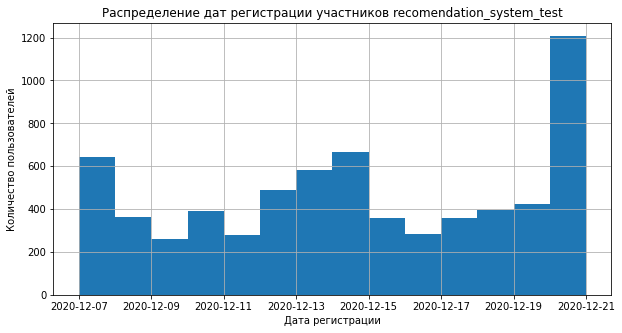

In [30]:
rec_users['first_date'].hist(
    figsize=(10, 5),
    bins=14
)
plt.title('Распределение дат регистрации участников recomendation_system_test')
plt.xlabel('Дата регистрации')
plt.ylabel('Количество пользователей')
plt.show()

В датасете нет пользователей, зарегистрированных до 7 декабря 2020 года и  после 21 декабря 2020 года, что согласуется с указанными датами запуска и остановки набора новых пользователей в техзадании.

Рассмотрим соответствие **времени событий новых пользователей** требованиям техзадания (дата запуска: 2020-12-07, дата остановки: 2021-01-04):

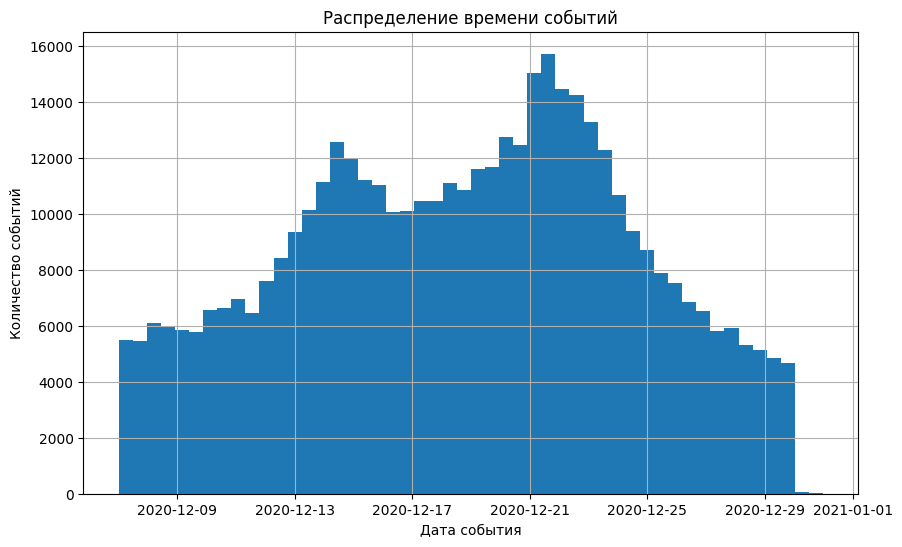

count                  440317
unique                 267268
top       2020-12-23 02:37:24
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

In [40]:
final_ab_events['event_dt'].hist(figsize=(10, 6), bins=50)
plt.title('Распределение времени событий')
plt.ylabel('Количество событий')
plt.xlabel('Дата события')
plt.show()

final_ab_events['event_dt'].describe()

Выводы:

В основном датасете с событиями новых пользователей данные с 7 по 30 декабря 2020 года
Не хватает данных с 2020-12-31 по 2021-01-04;
Не все новые пользователи успели "прожить" 14 дней, достаточные для выявления нужного эффекта от изменений, следовательно, это может привести к искажению результатов.

**Ключевые метрики**

В ходе этого теста мы должны зафиксировать улучшение не менее, чем на 10%, таких метрик:

- конверсии в просмотр карточек товаров — событие product_page,
- просмотры корзины — product_cart,
- покупки — purchase.

Сохраняем события участников а/б-теста:

In [41]:
rec_events = final_ab_events[
        final_ab_events['user_id'].isin(rec_users['user_id'])
]

Смотрим какие это события:

In [42]:
rec_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Присоединяем даты регистрации участников теста:

In [43]:
rec_events = rec_events.merge(
    rec_users[['user_id', 'first_date']],
    on='user_id'
)

Добавляем столбец с количеством дней, прошедших после регистрации:

In [44]:
rec_events['lifetime'] = (np.floor(
    (rec_events['event_dt'] - rec_events['first_date']) / np.timedelta64(1, 'D'))
).astype(int)

Оставляем события, произошедшие в первые 14 дней после момента регистрации:

In [45]:
rec_events = rec_events.query('lifetime <= 13')

В датасете имеются все события, по которым будут рассчитаны ключевые метрики.

### 3.2. Проверка совпадения времени теста с маркетинговыми активностями.

Выделяем кампании, нацеленные на EU:

In [46]:
ab_project_marketing_events['in_eu'] = ab_project_marketing_events['regions'].apply(
    lambda x: True if 'EU' in x else False
)

Сохраняем минимальную дату регистрации участников теста:

In [47]:
min_reg_date = final_ab_new_users['first_date'].min()
min_reg_date

Timestamp('2020-12-07 00:00:00')

In [48]:
display(ab_project_marketing_events.query('in_eu == True and start_dt >= "2020-12-07"'))

,name,regions,start_dt,finish_dt,in_eu
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True


Период проведения теста пересекается с маркетинговой кампанией Christmas&New Year Promo, которая стартовала 25 декабря 2020 года.

### 3.3. Проверка на пересечение тестовой аудитории с конкурирующим тестом

In [49]:
final_ab_participants['user_id'].duplicated().sum()

1602

Выявили 1602 дубликата в id пользователях. 

Сохраняем дублирующие id:

In [50]:
duplicated_users = final_ab_participants[final_ab_participants['user_id'].duplicated()]['user_id']

print(duplicated_users.shape[0])

final_ab_participants[
        final_ab_participants['user_id'].isin(duplicated_users)
]['ab_test'].unique()

1602


array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Данный датасет содержит 1602 пользователя, участвующие в двух A/B-тестах.
Для чистоты эксперимента желательно было бы удалить данные этих пользователей, но вданном случае мы этого сделать не можем, так как их удаление повлекло бы снижение количества участников теста ниже требуемого условиями техзадания. Поэтому просто отметим, что данный факт мог отрицательно повлиять на корректность проведения теста.

Ищем пользователей, оказавшихся в двух группах одновременно:

In [51]:
for test in final_ab_participants['ab_test'].unique():
    more_than_one = (
        final_ab_participants
            .query('ab_test == @test')
            .groupby('user_id')
            .agg({'group':'nunique'})
            .query('group > 1')
            .shape[0]
    )
    print(test)
    print('More than one group :', more_than_one)
    print()

recommender_system_test
More than one group : 0

interface_eu_test
More than one group : 0



Не нашлось ни одного участника, который оказался в обеих группах, в двух экспериментах.

### 3.4. Распределение пользователей по группам

Считаем распределение участников по группам А и В:

In [52]:
number_of_participants = (
    rec_participants
            .groupby('group', as_index=False)
            .agg({'user_id' : 'nunique'})
)
number_of_participants['percent'] = number_of_participants['user_id'] * 100 / number_of_participants['user_id'].sum()

Строим столбчатую диаграмму:

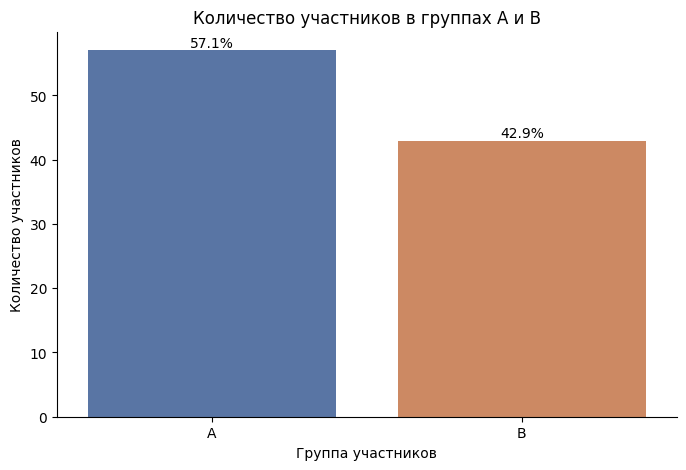

In [53]:
sns.set_palette('deep')
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=number_of_participants,
    x='group',
    y='percent'
)
plt.xlabel('Группа участников')
plt.ylabel('Количество участников')
plt.title('Количество участников в группах А и В')
ax.bar_label(ax.containers[0], fmt='%.1f%%')
sns.despine()
plt.show()

Разделение участников по группам А и В прошло не поровну:

- В группе А - 57,1%;
- В группе В - 42,9%.

In [ ]:
Добавляем столбцы с группой пользователя:

In [54]:
rec_users = rec_users.merge(
    rec_participants[['user_id', 'group']],
    on='user_id'
)
rec_events = rec_events.merge(
    rec_participants[['user_id', 'group']],
    on='user_id'
)

Рассмотрим распределение участников, совершивших хоть одно действие, по группам А и В:

In [55]:
users_agg = pd.melt(
    (rec_events # считаю пользователей, совершившие события
            .groupby('group')
            .agg(events=('user_id', 'nunique'))
            ).join(
                rec_users # считаю всех новых пользователей
                    .groupby('group')
                    .agg(all=('user_id', 'nunique'))
            ).T.reset_index()
             .rename(columns={'index' : 'users'}),
    # переплавливаю таблицу в длинный формат
    id_vars=['users'],
    var_name='group',
    value_name='users_cnt'
)

Строим барчарт:

Text(0.5, 1.0, 'Аудитория')

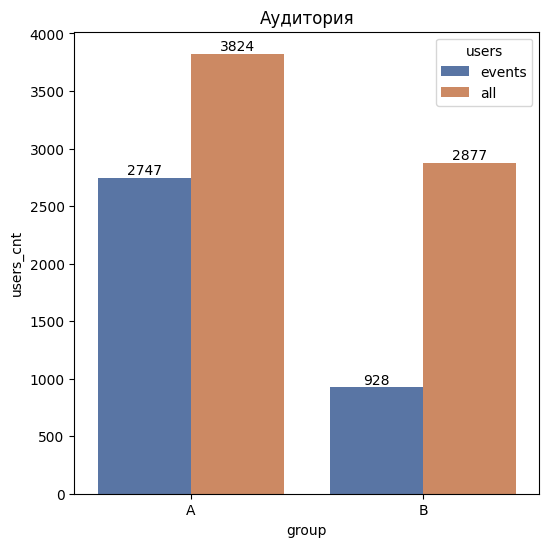

In [56]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(
    data=users_agg,
    x='group',
    y='users_cnt',
    hue='users'
)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Аудитория')

В ходе эксперимента не все участники воспользовались нашим продуктом:

- 71,6% пользователей группы А совершили хотя бы одно действие;
- 32,3% пользователей группы В совершили хотя бы одно действие.

То есть в группе В (новая платежная воронка) доля неактивных участников выше, чем в группе А (контрольной).

Рассмотрим распределение участников, одновременно принимающих участие в двух экспериментах, по группам А и В:

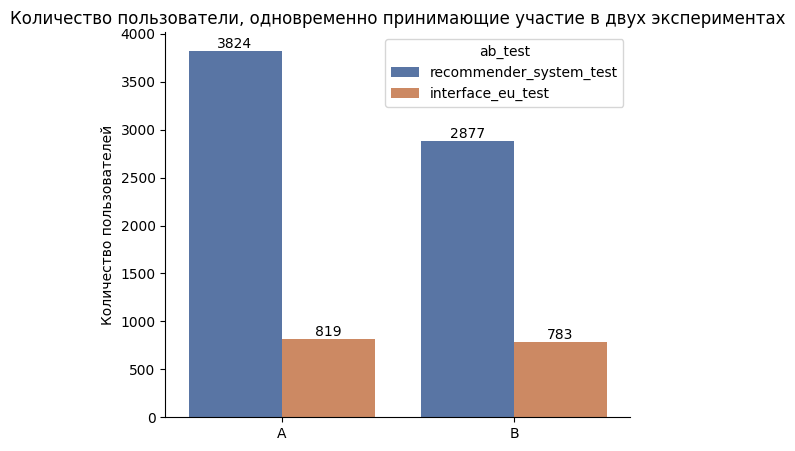

In [57]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(
    data=final_ab_participants[
        final_ab_participants['user_id'].isin(rec_users['user_id'])
    ],
    x='group',
    hue='ab_test'
)
for container in ax.containers:
    ax.bar_label(container)
sns.despine()
plt.title('Количество пользователи, одновременно принимающие участие в двух экспериментах')
plt.ylabel('Количество пользователей')
plt.xlabel('')
plt.show()

В группе В относительно больше пользователей, участвующих еще в параллельном эксперименте interface_eu_test:

- 22,5% в группе А;
- 28,8% в группе В.

### 3.5. Выводы по оценке корректности проведения теста:

**1. Соответствие данных требованиям технического задания**
- Количество пользователей, принявших участие в тестировании составляет 6701, это больше 6000, то есть соответствует количеству участников по техзаданию.
- Аудитория данного эксперимента - 15% из новых пользователей, зарегистрированных с 7 декабря по 21 декабря в Европе, что соответствует требованиям техзадания.
- В датасете нет пользователей, зарегистрированных до 7 декабря 2020 года и после 21 декабря 2020 года, что согласуется с указанными датами запуска и остановки набора новых пользователей в техзадании.
- В основном датасете с событиями новых пользователей данные с 7 по 30 декабря 2020 года. Не хватает данных с 2020-12-31 по 2021-01-04; 
- Не все новые пользователи успели "прожить" 14 дней, достаточные для выявления нужного эффекта от изменений, следовательно, это может привести к искажению результатов.
- В датасете имеются все события, по которым будут рассчитаны ключевые метрики.
   - конверсии в просмотр карточек товаров — событие product_page,
   - просмотры корзины — product_cart,
   - покупки — purchase.
   
**2. Пересечение с другими активностями** 
- Маркетинговая кампания Christmas&New Year Promo , прошедшая с 25 декабря 2020 года по 3 января 2021 года, пересекается с периодом проявления эффекта от изменений пользователей, которые зарегистрировались 11 декабря по 21 декабря 2020 года;
- Данный датасет содержит 1602 пользователя, участвующие в двух A/B-тестах.'recommender_system_test', 'interface_eu_test'
- Не нашлось ни одного участника, который оказался в обеих группах, в двух экспериментах.

**3. Аудитория теста**

- Разделение участников по группам А и В прошло не поровну:

   - В группе А - 57,1%;
   - В группе В - 42,9%.

- В ходе эксперимента не все участники воспользовались нашим продуктом:

   - 71,6% пользователей группы А совершили хотя бы одно действие;
   - 32,3% пользователей группы В совершили хотя бы одно действие.
То есть в группе В (новая платежная воронка) доля неактивных участников выше, чем в группе А (контрольной).

В группе В относительно больше пользователей, участвующих еще в параллельном эксперименте interface_eu_test:

   - 22,5% в группе А;
   - 28,8% в группе В

## 4. Исследовательский анализ данных

Посмотрим сколько событий приходится на одного пользователя:

In [58]:
print ('Усредненное количество событий на пользователя = ', \
    round (rec_events['event_name'].count() / rec_events['user_id'].nunique(), 0))

Усредненное количество событий на пользователя =  6.0


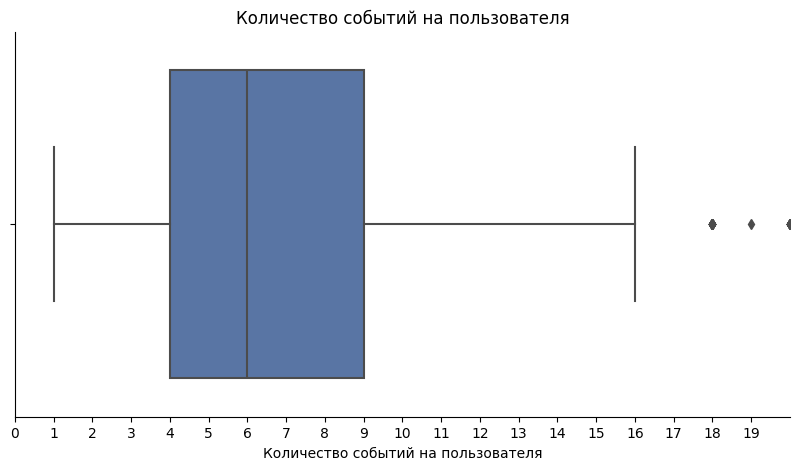

In [59]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=rec_events
            .groupby(['user_id'])
            .agg({'event_dt' : 'count'}),
    x='event_dt'
)
    
plt.title('Количество событий на пользователя')
plt.xlabel('Количество событий на пользователя')
plt.xticks((range(20)))
plt.xlim(0, 20)
sns.despine()
plt.show()

В среднем пользователи совершают 6 событий, что совпадает с медианным значением.

Сколько событий приходится на одного пользователя в группе А:

In [60]:
print ('Усредненное количество событий на пользователя в группе А = ', \
    round (rec_events.query('group == "A"')['event_name'].count() / rec_events.query('group == "A"')['user_id'].nunique(), 0))

Усредненное количество событий на пользователя в группе А =  7.0


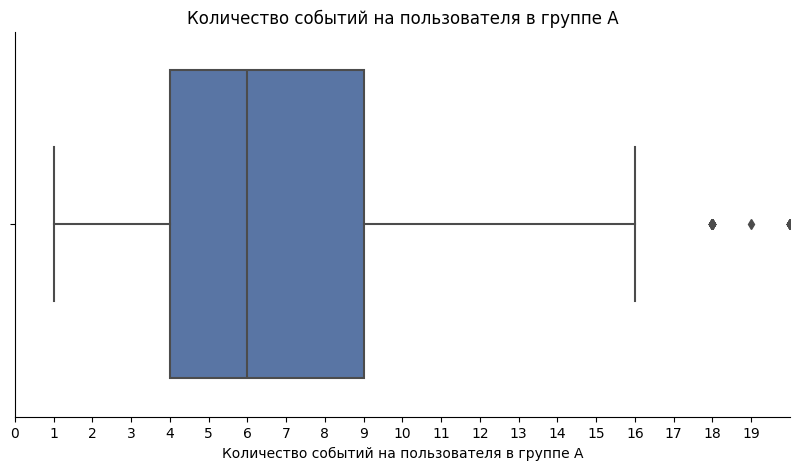

In [61]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=rec_events.query('group == "A"')
            .groupby(['user_id'])
            .agg({'event_dt' : 'count'}),
    x='event_dt'
)
    
plt.title('Количество событий на пользователя в группе А')
plt.xlabel('Количество событий на пользователя в группе А')
plt.xticks((range(20)))
plt.xlim(0, 20)
sns.despine()
plt.show()

В группе А пользователи совершают в среднем 7 событий, медианное значение - 6.

Сколько событий приходится на одного пользователя в группе В:

In [62]:
print ('Усредненное количество событий на пользователя в группе B = ', \
    round (rec_events.query('group == "B"')['event_name'].count() / rec_events.query('group == "B"')['user_id'].nunique(), 0))

Усредненное количество событий на пользователя в группе B =  5.0


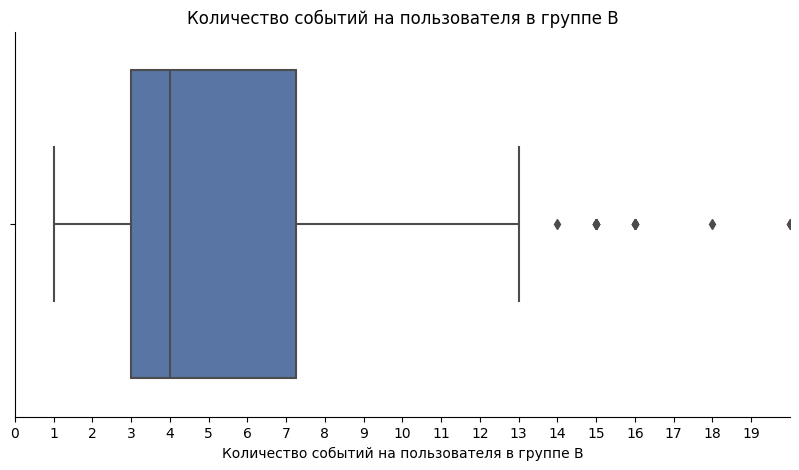

In [63]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=rec_events.query('group == "B"')
            .groupby(['user_id'])
            .agg({'event_dt' : 'count'}),
    x='event_dt'
)
    
plt.title('Количество событий на пользователя в группе В')
plt.xlabel('Количество событий на пользователя в группе В')
plt.xticks((range(20)))
plt.xlim(0, 20)
sns.despine()
plt.show()

В группе В пользователи совершают в среднем 5 событий, медианное значение - 4.

Выяснили, что показатели активности пользователей в группе А близка к общей активности участников А/В теста, а в группе В пользователи менее активны по сравнению с группой А и в целом с участниками теста . 

Количество всех событий на одного нового пользователя:

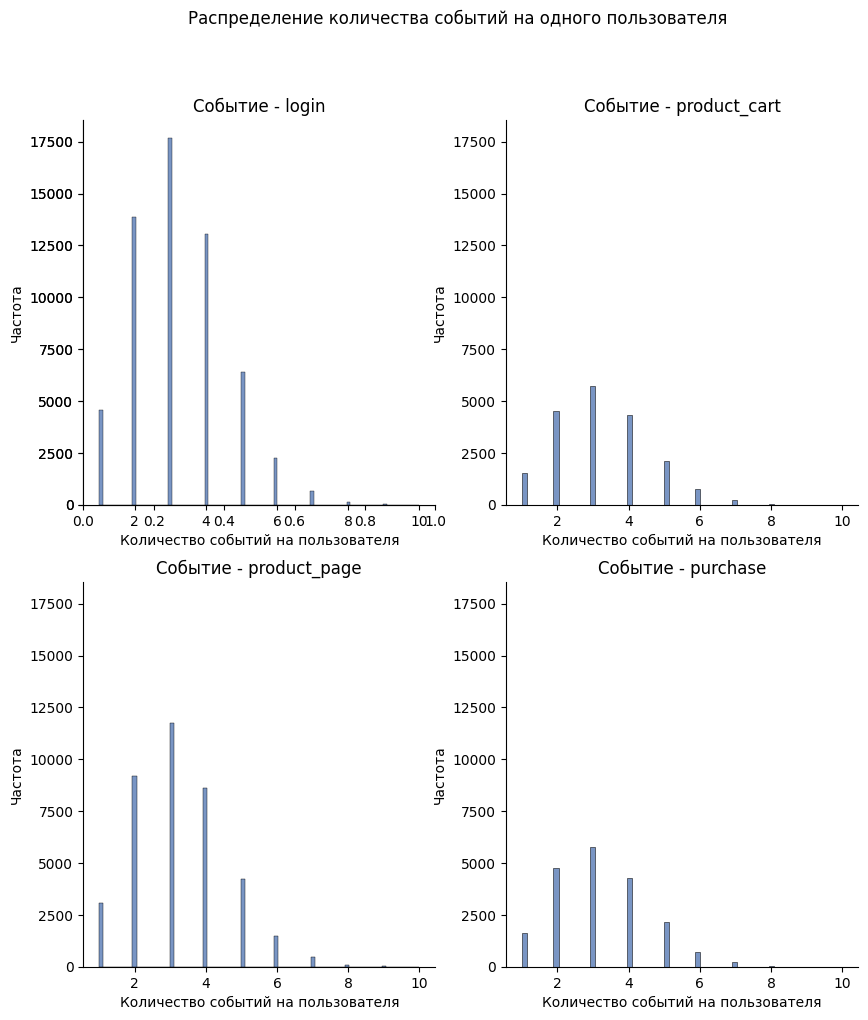

In [64]:
number_of_events = (
        final_ab_events
            .groupby(['user_id', 'event_name'], as_index=False)
            .agg({'event_dt' : 'count'})
    )

plt.figure(figsize=(10, 11))
for i, event in enumerate(number_of_events['event_name'].unique()):
        ax=plt.subplot(2, 2, i+1, sharey=(plt.subplot(2, 2, 1)))
        sns.histplot(
                data=number_of_events.query('event_name == @event'),
                x='event_dt',
                ax=ax)
    
        plt.title(f'Событие - {event}')
        plt.xlabel('Количество событий на пользователя')
        plt.ylabel('Частота')
        sns.despine()

plt.suptitle('Распределение количества событий на одного пользователя')
plt.show()

Выводы:

- Распределения событий выглядят нормальными;
- Большинство пользователей совершило до 6 действий каждого типа;
- Треть вошедших в сервис пользователей совершают покупку

Количество событий на одного участника а/б-теста:

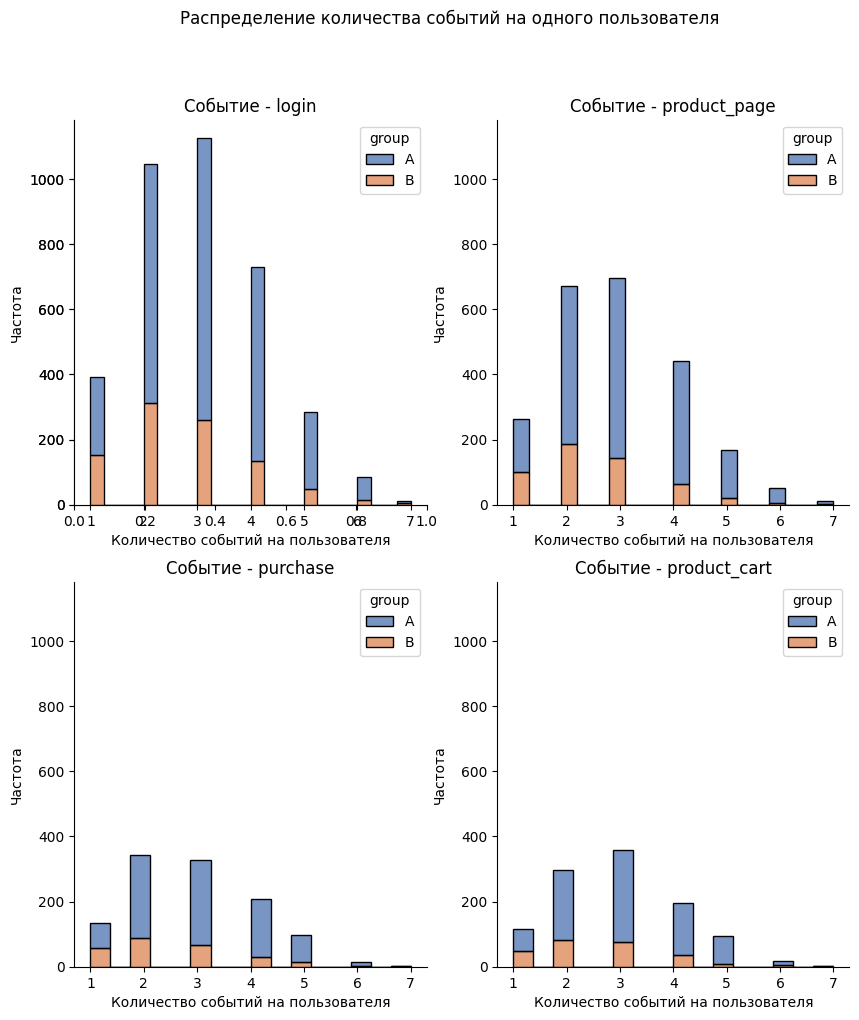

In [65]:
number_of_events = (
        rec_events
            .groupby(['group', 'user_id','event_name'], as_index=False)
            .agg({'event_dt' : 'count'})
    )

plt.figure(figsize=(10, 11))
for i, event in enumerate(number_of_events['event_name'].unique()):
        ax=plt.subplot(2, 2, i+1, sharey=(plt.subplot(2, 2, 1)))
        sns.histplot(
                data=number_of_events.query('event_name == @event'),
                x='event_dt',
                hue='group',
                multiple='stack',
                ax=ax
        )
    
        plt.title(f'Событие - {event}')
        plt.xlabel('Количество событий на пользователя')
        plt.ylabel('Частота')
        sns.despine()

plt.suptitle('Распределение количества событий на одного пользователя')
plt.show()


Выводы:

- Распределения имеют нормальный вид;
- Большинство пользователей совершают до 6 событий;
- Просмотр корзины и покупка случаются примерно в три раза реже, чем действие login;
- Участники теста практически не отличаются от всех пользователей, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

Изучим распределение количества событий пользователей по дням:

Создадим дополнительный столбец с днями исследования:

In [66]:
rec_events['day_of_december'] = rec_events['event_dt'].dt.strftime('%d')

Сгруппируем события по дням и построим столбчатую диаграмму:

In [68]:
events_count = rec_events.groupby('day_of_december')['event_name'].count().reset_index().rename(columns={'day_event_dt': 'day', 'event_name': 'count'})
fig = px.bar(events_count, 
             y='count', 
             x= 'day_of_december', 
             title = 'Общее количество действий пользователей',
             template = 'ggplot2'
             )
fig.update_layout(yaxis_title = 'Количество действий',
                 xaxis_title = 'Дата'
                 )
fig.update_xaxes(tickangle=45)
fig.update_traces(hovertemplate = 'День : %{x} <br>Количество: %{y}')

fig.show()

Выводы:

- Количество событий увеличивается с начала наблюдений, достигая своего максимума 21 декабря, затем частота уменьшается до конца декабря;
- Также видим два пика активности 14 и 21 декабря.

Изучим распределение количества событий пользователей по дням по группам

Сгруппируем события по дням и по группам и построим столбчатую диаграмму:

In [69]:
events_count_by_group = rec_events.groupby(['day_of_december','group'])['event_name'].count().reset_index().rename(columns={'day_event_dt': 'day', 'event_name': 'count'})

In [70]:
fig = px.bar(events_count_by_group, 
             y='count', 
             x= 'day_of_december', 
             title = 'Количество действий пользователей по группам', 
             template = 'ggplot2',
             color = 'group', barmode='group'
             )
fig.update_layout(yaxis_title = 'Количество действий',
                 xaxis_title = 'Дата'
                 )
fig.update_xaxes(tickangle=45)
fig.update_traces(hovertemplate = 'День : %{x} <br>Количество: %{y}')

fig.show()

Выводы:

- График событий участников теста из группы А практически повторяет график для всех пользователей;
- Активность участников группы В в начале тестирования мало отличались от активности группы А, но 14 числа активность участников группы А резко выросла и продолжила расти  до 21 числа, а активность участников группы В осталась на прежнем уровне;
- После 21 числа активность пошла на спад, как для участников группы А, так и для участников группы В.

Коэффициент удержания

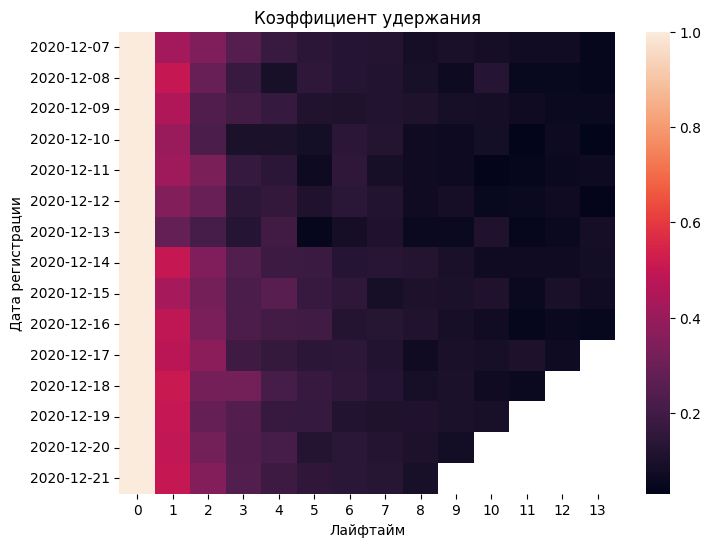

In [71]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    data=rec_events
        .assign(first_date = lambda x: x['first_date'].dt.date)
        .pivot_table(
                index='first_date',
                columns='lifetime',
                values='user_id',
                aggfunc='nunique')
        .apply(lambda x: x / x[0], axis=1)
)
ax.set(
    title='Коэффициент удержания',
    ylabel='Дата регистрации',
    xlabel='Лайфтайм'
)
plt.show()

Выводы:

- В первые три дня 40% пользователей возвращаются в сервис;
- Затем до первой недели эта метрика держится выше 20%.

**Динамика событий и регистраций новых пользователей**

Готовим данные для графика:

Пользователи:

In [72]:
users_temp = (
    rec_users
         .assign(first_date_dec = lambda x: x['first_date'].dt.strftime('%d'))
         .groupby(['first_date_dec', 'group'], as_index=False)
         .agg(users_cnt = ('user_id', 'nunique'))
)

События:

In [73]:
events_temp = (rec_events
                 .assign(event_date_dec = lambda x: x['event_dt'].dt.strftime('%d'))
                 .groupby(['event_date_dec', 'group'], as_index=False)
                 .agg(events_cnt = ('event_dt', 'count')))

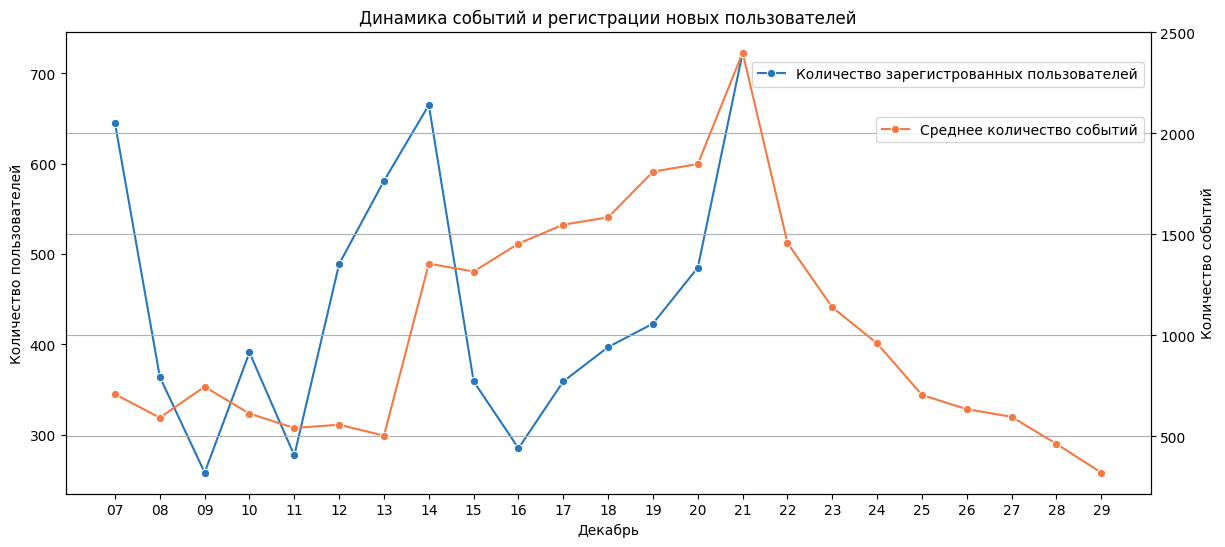

In [74]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

sns.lineplot(
    data=rec_users
         .assign(first_date_dec = lambda x: x['first_date'].dt.strftime('%d'))
         .groupby(['first_date_dec'], as_index=False)
         .agg(users_cnt = ('user_id', 'nunique')),
    x='first_date_dec',
    y='users_cnt',
    marker='o',
    label=f'Количество зарегистрованных пользователей',
    ax=ax1,
    color='#2677bb'
)
ax1.set(
    title='Динамика событий и регистрации новых пользователей',
    ylabel='Количество пользователей',
    xlabel='Декабрь'
)
ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.95))

ax2 = ax1.twinx()

sns.lineplot(
    data=rec_events
                 .assign(event_date_dec = lambda x: x['event_dt'].dt.strftime('%d'))
                 .groupby(['event_date_dec'], as_index=False)
                 .agg(events_cnt = ('event_dt', 'count')),
    x='event_date_dec',
    y='events_cnt',
    marker='o',
    ax=ax2,
    color='#f67944',
    label='Среднее количество событий'
)
ax2.set(ylabel='Количество событий')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.83))
plt.grid()
plt.show()

Выводы:

- так как 40% пользователей активно пользуются продуктом в первые три дня после регистрации, поэтому мы видим отложенный рост в количестве событий после такого же роста, только в наборе новых пользователей. Яркий пример этому - резкие скачки в наборе пользователей 11-12 декабря и количестве событий 13-14 декабря;
- Также после резкого падения набора новых пользователей мы не видим такого же падения в активности, так как в дело вступает накопительная активность пользователей зарегистрированных в последние 2-3 дня;
- После остановки регистрации новых участников теста число событий уменьшилось примерно в 10 раз за 8 дней.

**Анализ конверсии**

Последовательность в воронке можно выстроить так:

- login - вход в систему;
- product_page - просмотр товара;
- product_cart - просмотр корзины;
- purchase - покупка.

In [75]:
funnel_data = rec_events.pivot_table(
    index='event_name',
    columns='group',
    values='user_id',
    aggfunc='nunique'
).loc[['login', 'product_page', 'product_cart', 'purchase']]\
 .reset_index()

In [76]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = funnel_data['event_name'],
    x = funnel_data['A'],
    textinfo = "value+percent initial")
)

fig.add_trace(go.Funnel(
    name = 'B',
    y = funnel_data['event_name'],
    x = funnel_data['B'],
    textinfo = "value+percent initial")
)
fig.update_layout(
    yaxis_title='Тип события',
    title='Воронка конверсии'
)
fig.show()

Выводы:

- Падение конверсии группы В на стадии просмотра товара упала на 9%;
- Разница в конверсиях на стадиях просмотра корзины и покупки на уровне погрешности, так как в техзадании указано, что ждут улучшение на 10% и не менее. Чтобы зафиксировать разницу меньше 10%, необходимо планировать эксперимент с большим количеством участников.

### Выводы по исследовательскому анализу данных:

- Количество событий на одного участника а/б-теста:

   - В среднем пользователи совершают 6 событий, что совпадает с медианным значением.
   - В группе А пользователи совершают в среднем 7 событий, медианное значение - 6.
   - В группе В пользователи совершают в среднем 5 событий, медианное значение - 4.
   - Выяснили, что показатели активности пользователей в группе А близка к общей активности участников А/В теста, а в группе В пользователи менее активны по сравнению с группой А и в целом с участниками теста .

- Количество событий на одного нового пользователя:
   - Распределения событий выглядят нормальными;
   - Большинство пользователей совершило до 6 действий каждого типа;
   - Треть вошедших в сервис пользователей совершают покупку

- Количество событий на одного участника а/б-теста:
   - Распределения имеют нормальный вид;
   - Большинство пользователей совершают до 6 событий;
   - Просмотр корзины и покупка случаются примерно в три раза реже, чем действие login;
   - Участники теста практически не отличаются от всех пользователей, зарегистрировавшиеся в интернет-магазине в период с 7 по   21 декабря 2020 года;

- Распределение событий новых пользователей по дням:
   - Количество событий увеличивается с начала наблюдений, достигая своего максимума 21 декабря, затем частота уменьшается до конца декабря;
   - Также видим два пика активности 14 и 21 декабря.

- Распределение событий участников а/б-теста по дням:
   - Количество событий увеличивается с начала наблюдений, достигая своего максимума 21 декабря, затем частота уменьшается до конца декабря;
   - Также видим два пика активности 14 и 21 декабря.
   - График событий участников теста из группы А практически повторяет график для всех пользователей;
   - Активность участников группы В в начале тестирования мало отличались от активности группы А, но 14 числа активность участников группы А резко выросла и продолжила расти до 21 числа, а активность участников группы В осталась на прежнем уровне;
   - После 21 числа активность пошла на спад, как для участников группы А, так и для участников группы В.
   

- Изучение коэффициэнта удержания показало, что:
   - В первые три дня 40% пользователей возвращаются в сервис;
   - Затем до первой недели эта метрика держится выше 20%.

- Динамика событий и регистраций новых пользователей
   - Так как 40% пользователей активно пользуются продуктом в первые три дня после регистрации, мы видим отложенный рост в количестве событий после такого же роста, только в наборе новых пользователей. Пример - резкие скачки в наборе пользователей 11-12 декабря и количестве событий 13-14 декабря;
   - Также после резкого падения набора новых пользователей мы не видим такого же падения в активности, так как в дело вступает накопительная активность пользователей зарегистрированных в последние 2-3 дня;
   - После остановки регистрации новых участников теста число событий уменьшилось примерно в 10 раз за 8 дней.

- Анализ конверсии
   - Падение конверсии группы В на стадии просмотра товара упала на 9%;
   - Разница в конверсиях на стадиях просмотра корзины и покупки на уровне погрешности, так как в техзадании указано, что ждут улучшение на 10% и не менее. Чтобы зафиксировать разницу меньше 10%, необходимо планировать эксперимент с большим количеством участников.
   
   
**Прежде чем приступать к А/В- тестированию нужно учесть следующие особенности данных:**

- Отсутствуют данные о действиях пользователей с 31.12.2020 по 04.01.2021.
- В период проведения теста для интересующих нас пользователей параллельно проходила акция Christmas&New Year Promo.
- Во время иследования мы выяснили, что параллельно проходило другое тестирование, аудитория которого пересекается с нашим тестом. Для чистоты эксперимента требуется удаление не репрезентативных пользователей, но при этом аудитория теста снижается ниже требований техзадания.
- Медианы по количеству совершенных действий у пользователей в группах различаются. У группы А - 6, у группы В - 4.

## 5. Оценка результатов А/В тестирования

В техзадании указано, что в первые две недели после регистрации покажут улучшение ключевых метрик не менее, чем на 10%:

- конверсии в просмотр карточек товаров;
- просмотры корзины;
- покупки.

**Расчет метрик**

In [77]:
rec_events = rec_events.drop(columns=['day_of_december'])

In [78]:
main_funnel = (rec_events
    .pivot_table(
        index='event_name',
        columns='group',
        values='user_id',
        aggfunc='nunique')
).loc[['login', 'product_page', 'product_cart', 'purchase']]

In [79]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = main_funnel.index,
    x = main_funnel['A'],
    textinfo = "value+percent initial")
)

fig.add_trace(go.Funnel(
    name = 'B',
    y = main_funnel.index,
    x = main_funnel['B'],
    textinfo = "value+percent initial")
)
fig.update_layout(
    yaxis_title='Тип события',
    title='Воронка конверсии в первые 14 дней после регистрации'
)
fig.show()

Выводы:

- На стадии просмотра товара у группы В видим падение конверсии на 9%;
- На стадиях просмотра корзины и покупки у группы В конверсия на 2% и 3% меньше соответственно;
- Совершили покупку все пользователи, которые просмотрели корзину;
- На этапе покупки у контрольной группы конверсия на 1% больше, чем на этапе product_cart, что может свидетельствовать о    необязательности в воронке стадии просмотра корзины.

Объявление функции для расчета z-критерия

In [80]:
def z_value(group_1_successes, # число успешных событий первой группы
            group_1_trials, # число всех событий первой группы
            group_2_successes, # число успешных событий второй группы
            group_2_trials, # число всех событий второй группы
            alpha # задаю критический уровень статистический значимости
):

    p1 = group_1_successes / group_1_trials
    
    p2 = group_2_successes / group_2_trials

    p_comb = (group_1_successes + group_2_successes
         ) / (group_1_trials + group_2_trials)

    diff = p1 - p2

    z_value = diff / math.sqrt(
        p_comb * 
        (1 - p_comb) * 
        (1 / group_1_trials + 1 / group_2_trials)
    )


    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'P-уровень значимости : {p_value}')

    if p_value < alpha:
        print('Нулевая гипотеза отвергнута')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу')

Зададим критический уровень. Учитывая, что мы одновременно проводим 4 теста, необходимо применить одну из поправок, для исключения ошибки первого рода. Применем метод Шидока:

In [81]:
alpha = 1 - (1 - 0.05)**(1/4)
print('Критический уровень статистический значимости: ', alpha)

Критический уровень статистический значимости:  0.012741455098566168


**Проведение статистических тестов**

Необходимо проверить статистическую разницу долей z-критерием:

- конверсии в просмотр карточек товаров — событие product_page,
- просмотры корзины — product_cart,
- покупки — purchase.

Проверяем конверсию в просмотр карточек товаров z-критерием:
- H 0 : пропорции пользователей групп А и В, которые совершили действие product_page, равны;
- H A : пропорции групп отличаются.

In [82]:
z_value(
    # число пользователей группы А, совершивших событие product_page
    main_funnel.loc['product_page', 'A'], 
    # число пользователей группы A, совершивших событие login
    main_funnel.loc['login', 'A'], 
    # число пользователей группы B, совершивших событие product_page
    main_funnel.loc['product_page', 'B'], 
    # число пользователей группы B, совершивших событие login
    main_funnel.loc['login', 'B'],
    # задаю пороговый уровень статистической значимости
    alpha=0.012741455098566168
)

P-уровень значимости : 5.084368080776613e-06
Нулевая гипотеза отвергнута


Результаты статистического теста дают нам основания сказать, что у группы В конверсия в просмотры карточек хуже.

Проверяем конверсию в просмотр корзины:
- H 0 : пропорции пользователей групп А и В, которые совершили действие product_cart, равны;
- H A : пропорции групп отличаются.

In [83]:
z_value(
    # число пользователей группы А, совершивших событие product_page
    main_funnel.loc['product_cart', 'A'], 
    # число пользователей группы A, совершивших событие login
    main_funnel.loc['login', 'A'], 
    # число пользователей группы B, совершивших событие product_page
    main_funnel.loc['product_cart', 'B'], 
    # число пользователей группы B, совершивших событие login
    main_funnel.loc['login', 'B'],
    # задаю пороговый уровень статистической значимости
    alpha=0.012741455098566168
)

P-уровень значимости : 0.15034216422194624
Нет оснований отвергнуть нулевую гипотезу


Z-критерий показал, что различия в конверсиях просмотра корзины статистически не существенны.

Проверяю конверсию в покупки:
- H 0 : пропорции пользователей групп А и В, которые совершили действие purchase, равны;
- H A : пропорции групп отличаются.

In [84]:
z_value(
    # число пользователей группы А, совершивших событие purchase
    main_funnel.loc['purchase', 'A'], 
    # число пользователей группы A, совершивших событие login
    main_funnel.loc['login', 'A'], 
    # число пользователей группы B, совершивших событие purchase
    main_funnel.loc['purchase', 'B'], 
    # число пользователей группы B, совершивших событие login
    main_funnel.loc['login', 'B'],
    # задаю пороговый уровень статистической значимости
    alpha=0.012741455098566168
)

P-уровень значимости : 0.018474632659979617
Нет оснований отвергнуть нулевую гипотезу


Различия в конверсии в покупки у группы В статистически не существенны.

### Выводы по оценке результатов А/В тестирования:

- До действия login дошли только:
   - 71,7% от общего количества участников или 2604 пользователей из группы А;
   - 32,3% от общего количества участников или 877 пользователей из группы В.
   
   
- Конверсия в просмотры карточек товаров составила:
   - группа А - 65% (1685 пользователей);
   - группа В - 56% (493 пользователей).
Эта разница статистически значима.


- Конверсия в просмотры корзины:
   - группа А - 30% (782 пользователей);
   - группа В - 28% (244 пользователей).
Нет оснований утверждать, что эта разница статистически значима.


- Конверсия в покупки:
группа А - 32% (833 пользователей);
группа В - 28% (249 пользователей).
Нет оснований утверждать, что эта разница статистически значима.


**Тесты показали, что ухудшение ключевых метрик в группе В статистически значимо только для конверсии в просмотры карточек. Для конверсии в просмотры корзины и конверсии в покупки нет оснований утверждать, что эта разница статистически значима.**

## 6. Общие выводы

**Перед нами была поставлена задача оценить корректность проведения A/B теста и проанализировать его результаты.**

**Было предоставлено техническое задание и данные четырех датасетов:**

Данные из таблиц ab_project_marketing_events, final_ab_new_users, final_ab_events, final_ab_participants были изучены. В результате были сделаны следующие выводы и преобразования:

**ab_project_marketing_events**

- представляет календарь маркетинговых событий на 2020 год;
- содержит сведения о 13 маркетинговых событиях на 2020 год, регионы и даты их проведения;
- в столбцах 'start_dt' и 'finish_dt' были преобразованы данные из типа object в datetime;
- пропуски и дубликаты не содержит.

**final_ab_new_users**

-  содержит сведения о 61734 уникальных пользователях зарегистрировавшихся с 7 по 21 декабря 2020 года;
- пропуски и дубликаты не содержит;
- данные в столбце 'first_date' были преобразованы из типа object в datetime;
- столбец 'region' содержит регионы новых пользователей: EU, N.America, APAC, CIS;
- столбец 'device' содержит список устройств, с которых происходила регистрация: PC, Android, iPhone, Mac.

**final_ab_events**

- состоит из 4 столбцов и содержит 440318 строк;
- содержит сведения о действиях 58703 пользователей в период с 7 декабря 00:00:00 по 30 декабря 23:00:00 2020 года, а также дополнительная информацию об этих событиях;
- в столбце 'details' были обнаружены пропуски;
- анализ пропусков показал, что строки с отсутствующими значениями в столбце 'details' - это события, не являющимися покупками; - информация о событиях в таблице присутствует только для покупок - purchase, в этом поле хранится стоимость покупки в долларах;
- в cтолбце 'event_name' данные были преобразованы c типа object в datetime;
- явных дубликатов не выявлено.

**final_ab_participants**

- таблица final_ab_participants состоит из 3 столбцов и 18268 строк и содержит сведения о 16666 участниках тестов;
- пропусков и явных дубликатов нет;
- в столбце 'group' два варианта групп - А и В;
- в столбце 'ab_test' два варианта названия тестов - recommender_system_test и interface_eu_test.

**Далее нами были проведены этапы:**

**Оценка корректности проведения теста:**
   - на соответствие данных требованиям технического задания;
   - проверка времени проведения теста;
   - исследование аудитории теста.
   
**Исследовательский анализ данных:**
   - как количество событий на пользователя распределены в выборках;
   - как число событий в выборках распределено по дням;
   - как меняется конверсия в воронке в выборках на разных этапах;
   - какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию.
   
**Оценка результатов A/B-тестирования:**
   - что можно сказать про результаты A/B-тестирования;
   - проверка статистической разницы долей z-критерием.
   

**В ходе проведенного исследования были выявлены ошибки и нарушения техзадания:**

- Отсутствуют данные о действиях пользователей с 31.12.2020 по 04.01.2021;

- В период проведения теста для интересующих нас пользователей параллельно проходила акция Christmas&New Year Promo;

- Во время иследования мы выяснили, что параллельно проходило другое тестирование, аудитория которого пересекается с нашим тестом. Для чистоты эксперимента было бы желательно удалить не репрезентативных пользователей, но так как при этом аудитория теста снижается ниже требований техзадания, данные оставили без изменеия;

- Доли количества участников теста неравноценны: в группе А - 57,1%, в группе В - 42,9%;

- Для активных участников (для пользователей, совершивших хотя бы одно действие) различие в долях выражено еще сильнее: в группе А - 71,6%, в группе В - 32,3%;

- Медианы по количеству совершенных действий у пользователей в группах различаются. У группы А - 6, у группы В - 4;

- в группе А до конца воронки (совершения целевого действия - покупки) доходит на 4% больше пользователей чем в группе B (32%/28% соответственно)

- По результатам множественного тестирования, 3 действиям (login, product_cart, purchase) не удалось отвергнуть нулевую гипотезу. Нет оснований считать, что доли пользователей разные. По действию product_page отвергнули гипотезу, доли разные.
При этом у группы В конверсия в просмотры карточек хуже, а не лучше, как ожидалось.

**Учитывая вышесказанное, проведенное тестирование не вызывает доверия. Советуем подготовить данные заново, провериь их целостность и соответствие ТЗ и провести тестирование заново.**